In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src_torch
/home/akarsh_sakana_ai/.conda/envs/spaghetti_torch/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms


In [4]:
from cppn import CPPN, PixelDofs

In [123]:
target_img = plt.imread('../dog.jpg')/255.
target_img = einop(torch.from_numpy(target_img), "H W D -> D H W")

# resize to 224, 224, 3
target_img = torchvision.transforms.Resize((224, 224))(target_img)
target_img = einop(target_img, "D H W -> H W D")

target_img = target_img.cuda()

cppn = CPPN(4, 32).cuda()

opt = torch.optim.Adam(cppn.parameters(), lr=3e-4)

n_iters = 100000
losses = []
for i in tqdm(range(n_iters)):
    img = cppn.generate_image(img_size=224, device='cuda')
    loss = ((img - target_img)**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if (i+1)%(n_iters//5) == 0:
        plt.figure(figsize=(20, 5))
        plt.subplot(131); plt.plot(losses); plt.yscale('log')
        plt.subplot(132); plt.imshow(target_img.detach().cpu().numpy())
        plt.subplot(133); plt.imshow(img.detach().cpu().numpy())
        plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
from transformers import AutoProcessor, CLIPModel

clip_model="clip-vit-base-patch32"
processor = AutoProcessor.from_pretrained(f"openai/{clip_model}")
clip_model = CLIPModel.from_pretrained(f"openai/{clip_model}").cuda()
img_mean = torch.Tensor(processor.image_processor.image_mean).cuda()
img_std = torch.Tensor(processor.image_processor.image_std).cuda()

# set requires grad on parameter to False
for p in clip_model.parameters():
    p.requires_grad = False

def embed_img(img):
    """
    img shape (B H W C) and values in [0, 1].
    returns shape (D)
    """
    _, H, W, C = img.shape
    assert H==224 and W==224
    img = rearrange((img-img_mean)/img_std, "B H W C -> B C H W")
    z_img = clip_model.get_image_features(img)
    return z_img / z_img.norm(dim=-1, keepdim=True)

def embed_txt(prompts):
    """
    prompts is list of strings
    returns shape (B D)
    """
    inputs = processor(text=prompts, return_tensors="pt", padding=True)
    z_text = clip_model.get_text_features(input_ids=inputs['input_ids'].cuda(), attention_mask=inputs['attention_mask'].cuda())
    return z_text / z_text.norm(dim=-1, keepdim=True)

augment_fn = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
    # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

  0%|          | 0/10000 [00:00<?, ?it/s]

-0.3604174256324768


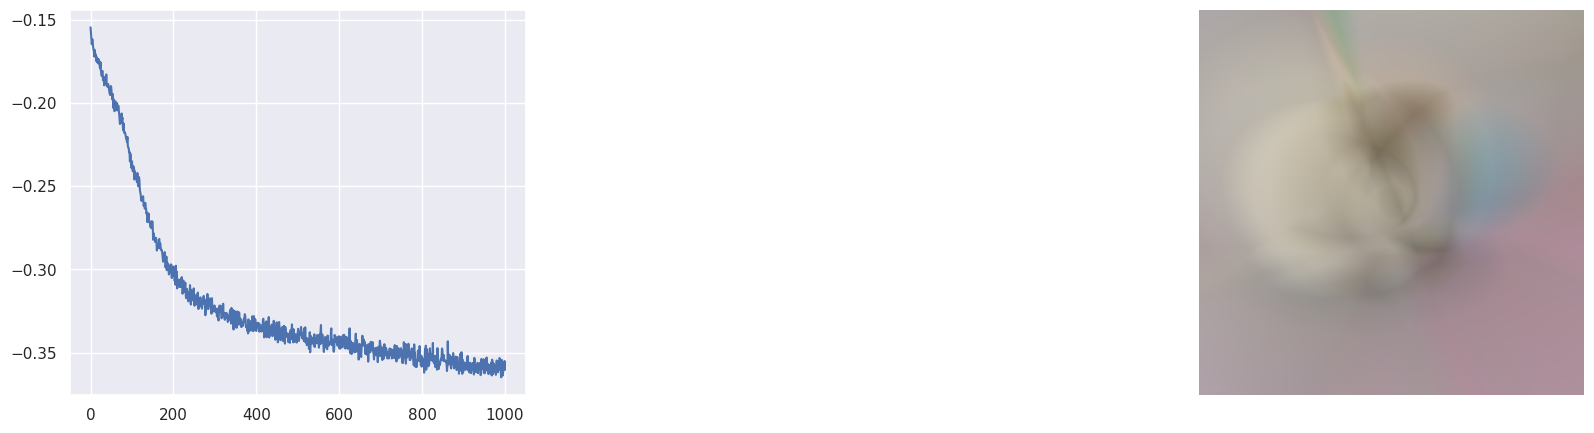

-0.3997025787830353


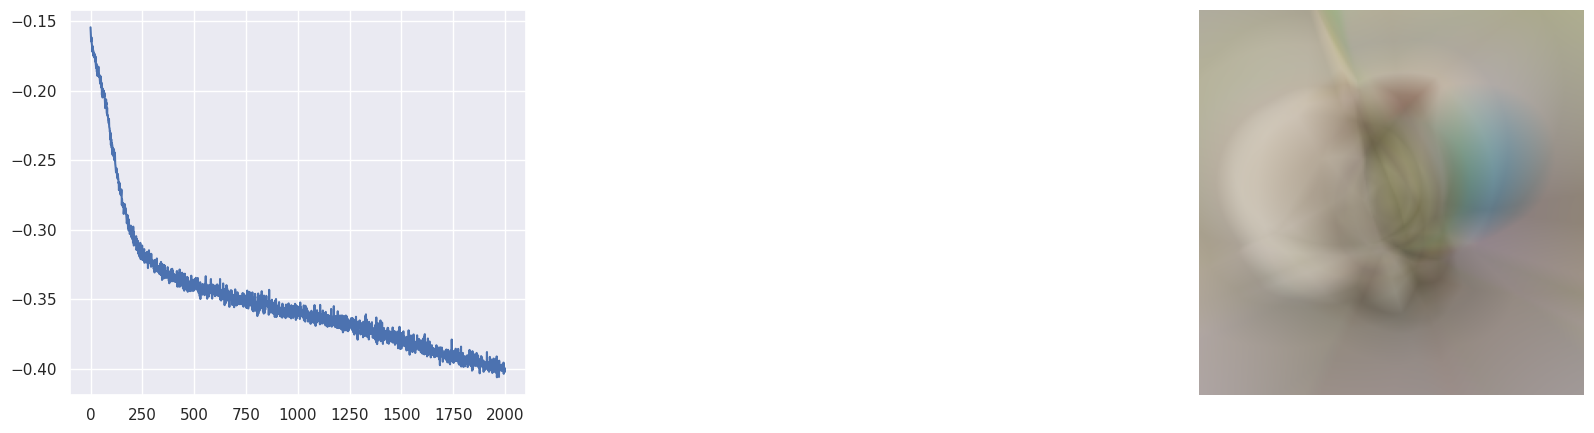

-0.4098537564277649


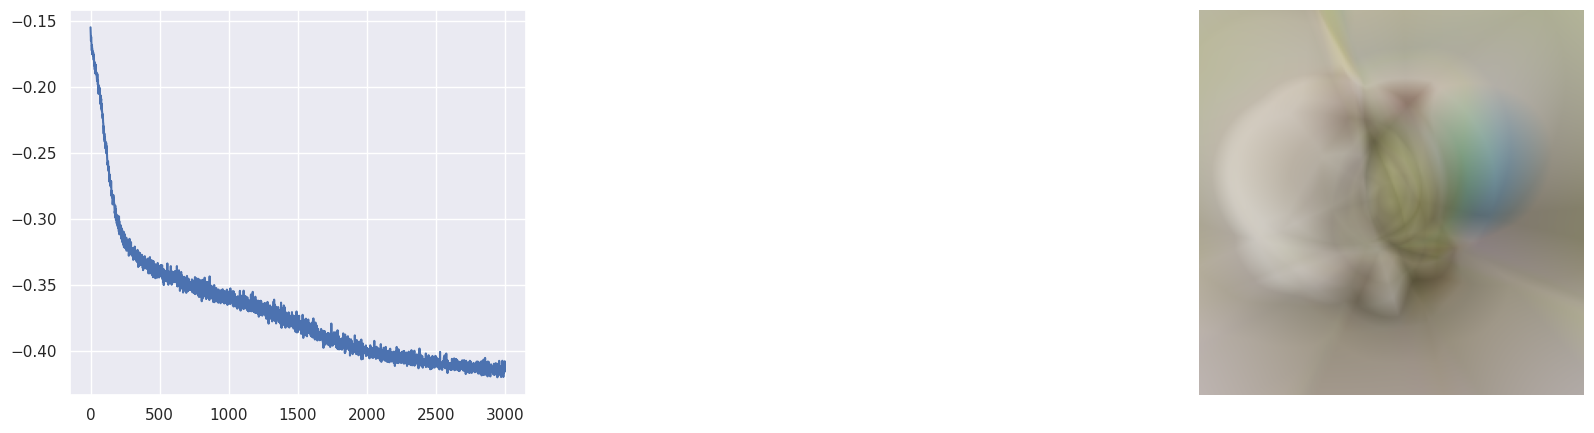

-0.423960417509079


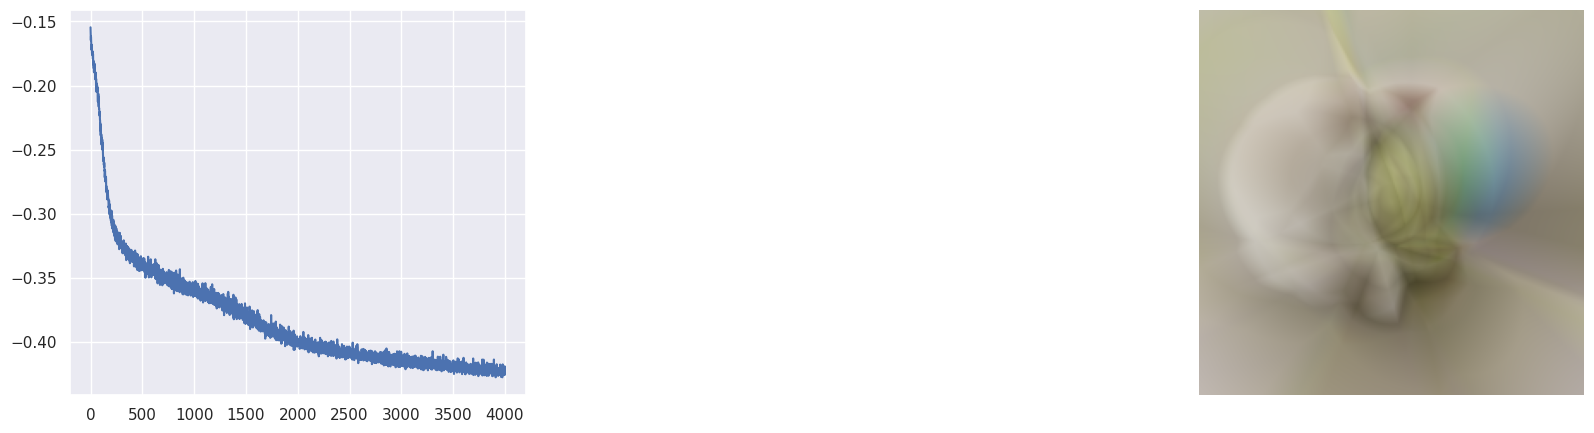

-0.43148714303970337


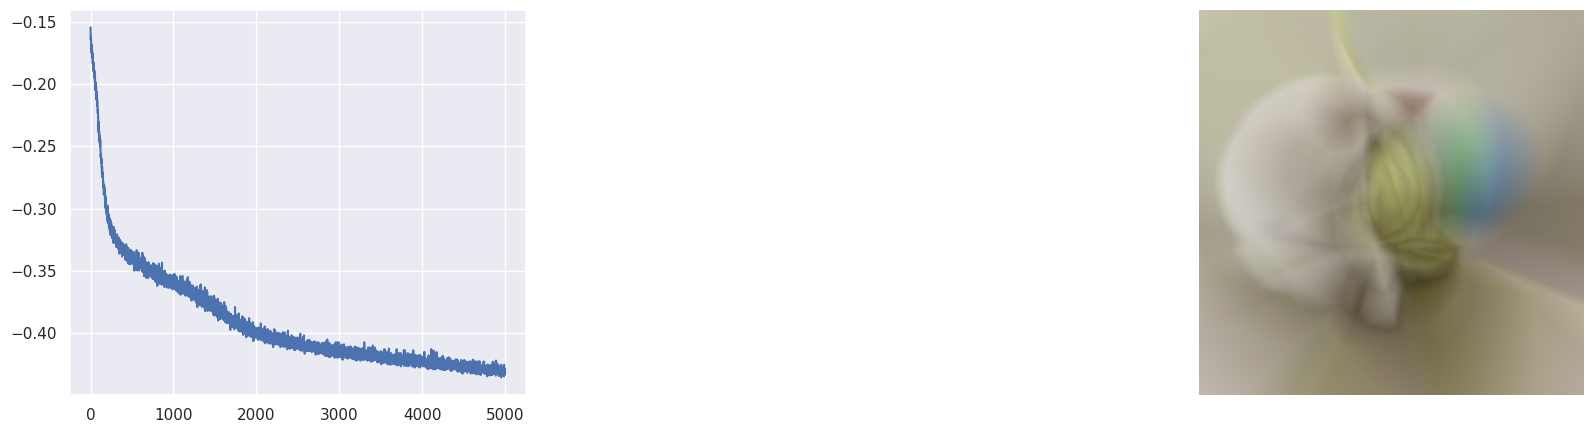

-0.43612951040267944


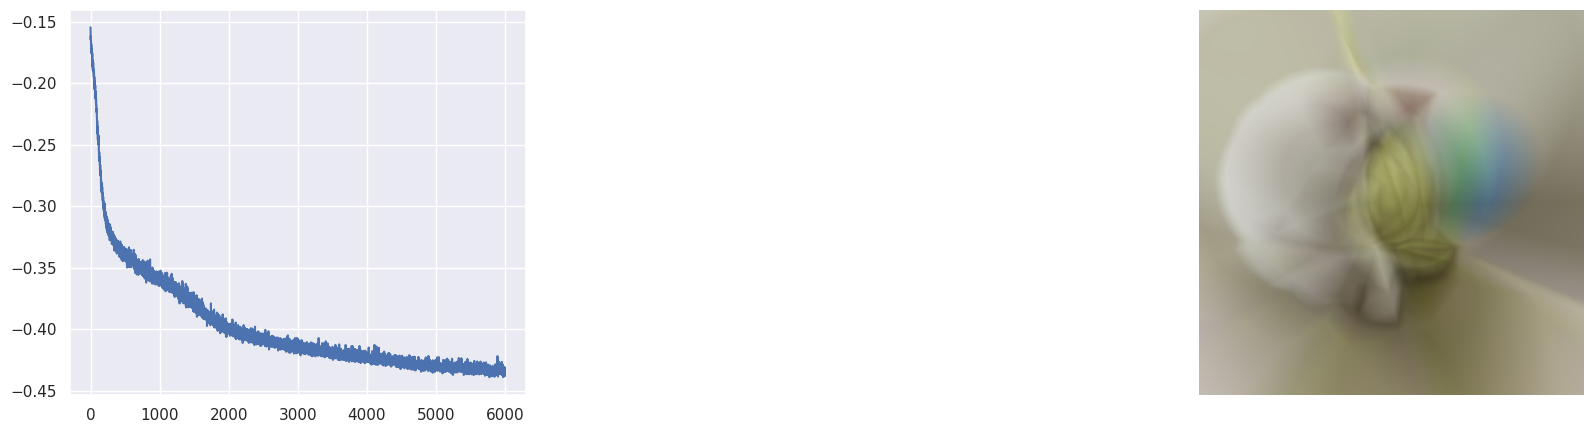

-0.4398108124732971


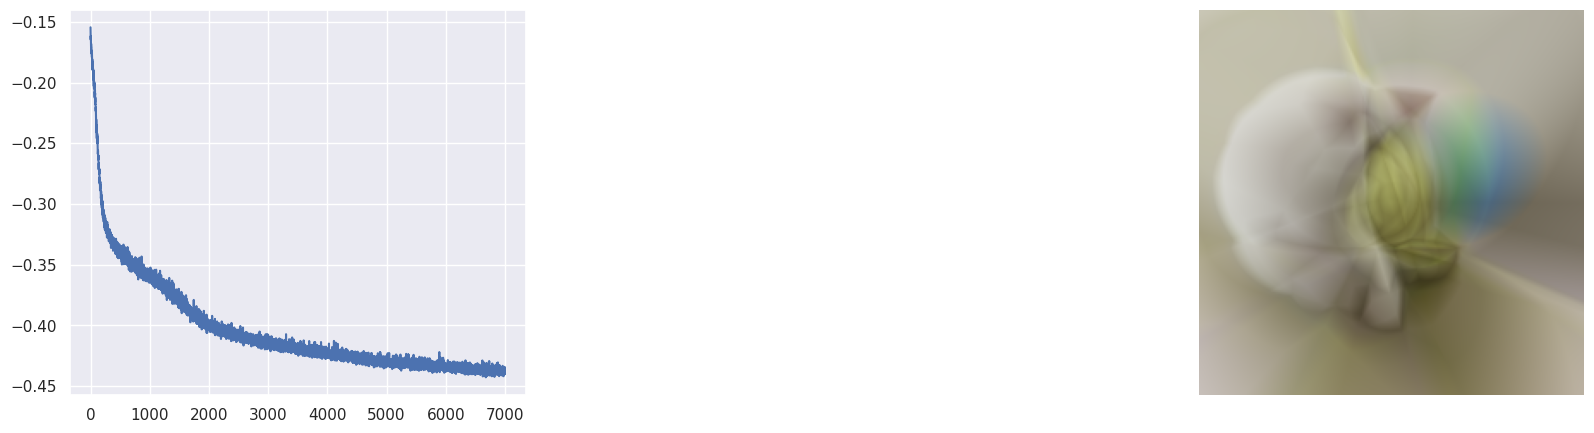

-0.4411604404449463


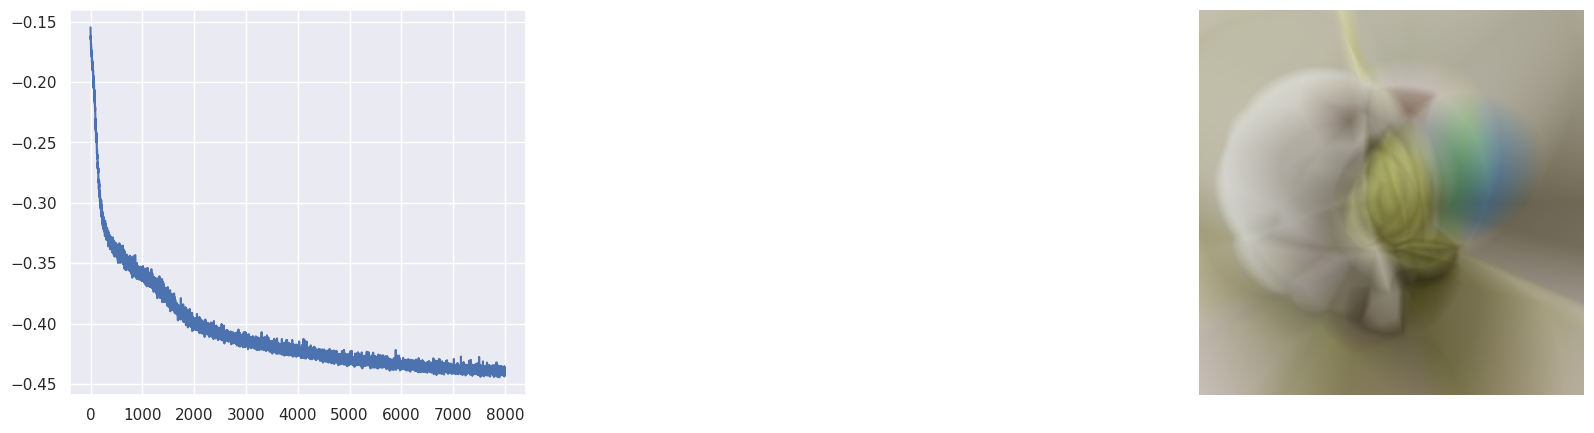

-0.43812936544418335


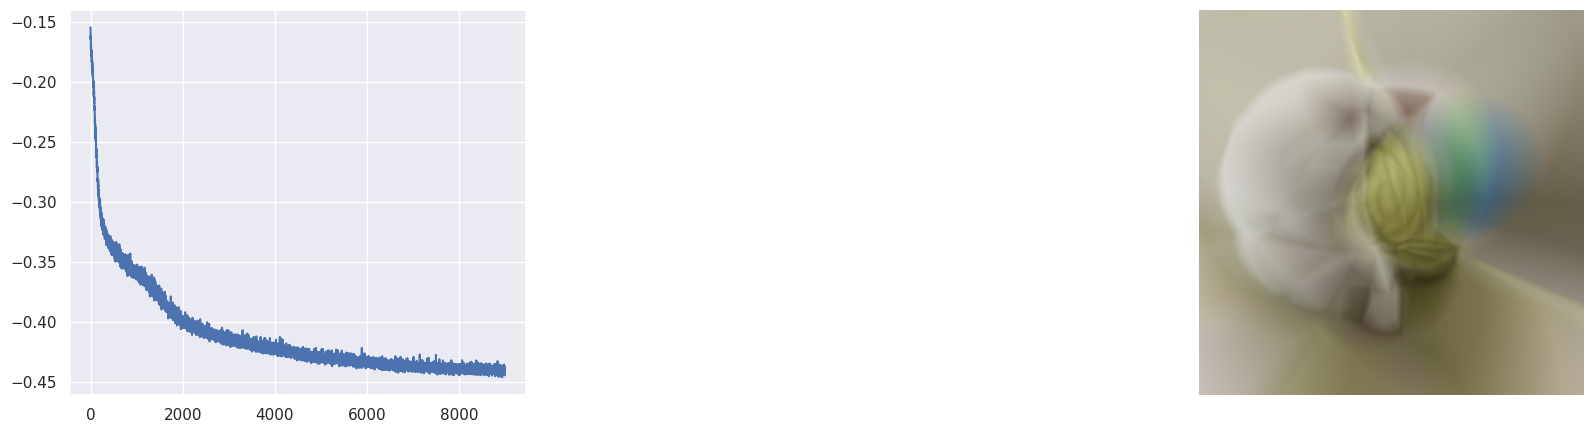

-0.4418845772743225


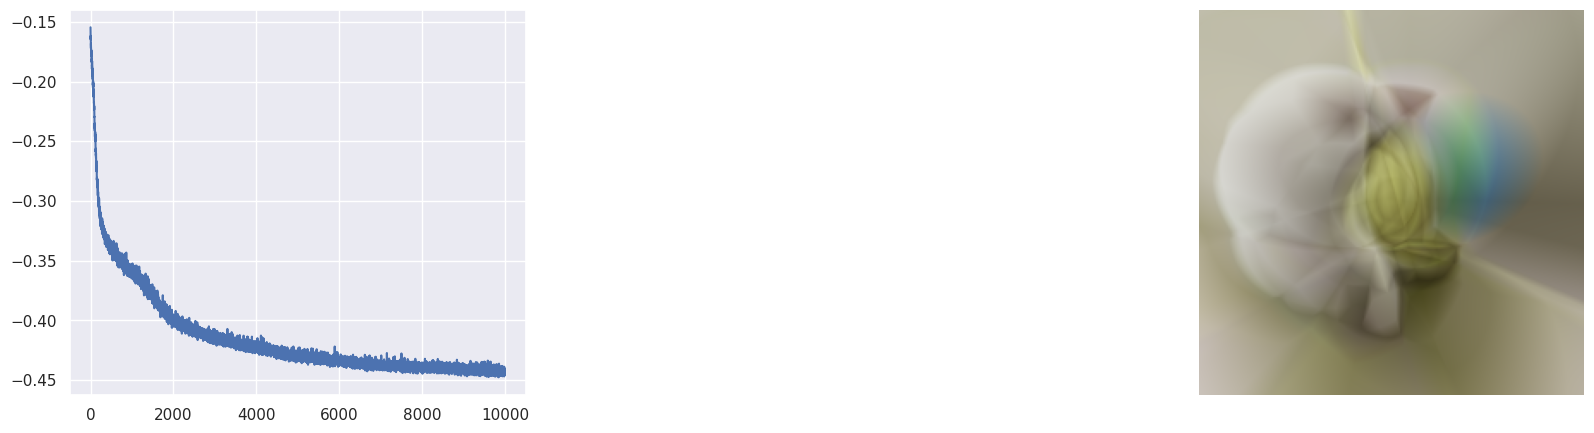

In [26]:
torch.manual_seed(0)

prompt = "a cute cat playing with a ball of yarn"
# prompt = "mountains with a waterfall"
z_txt = embed_txt([prompt])[0]

cppn = CPPN(4, 16, 'relu').cuda()
# cppn = PixelDofs().cuda()

# opt = torch.optim.Adam(cppn.parameters(), lr=5e-2)
opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)

n_iters = 10000
losses = []
pbar = tqdm(range(n_iters))
for i in pbar:
    img = cppn.generate_image(img_size=224, device='cuda')

    img_aug = einop(img, "H W D -> D H W")
    img_aug = torch.stack([augment_fn(img_aug) for _ in range(16)])
    img_aug = einop(img_aug, "... D H W -> ... H W D")

    z_img = embed_img(img_aug)
    score = (z_img @ z_txt)
    loss = -score.mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if i%100 == 0:
        pbar.set_postfix(loss=loss.item())
    if (i%(n_iters//10) == 0 and i>0) or i==n_iters-1:
        print(loss.item())
        plt.figure(figsize=(20, 5))
        plt.subplot(131); plt.plot(losses)#; plt.yscale('log')
        # plt.subplot(132); plt.imshow(target_img.detach().cpu().numpy())
        plt.subplot(133); plt.imshow(img.detach().cpu().numpy()); plt.axis('off')
        plt.show()


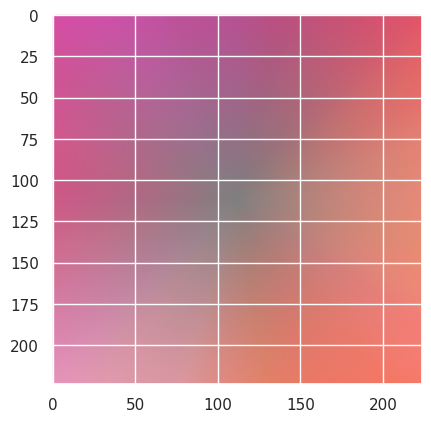

In [21]:
torch.manual_seed(0)
cppn = CPPN(4, 32, 'relu').cuda()

img = cppn.generate_image(img_size=224, device='cuda')
plt.imshow(img.detach().cpu().numpy())

In [33]:
img = plt.imread("../cat.jpg")/255.
img = img[:224, :224]
img = torch.from_numpy(img)
z_img = embed_img(img[None].cuda())[0]

In [35]:
print(z_img.max().item(), z_img.min().item(), z_img.mean().item(), z_img.std().item())

0.15642540156841278 -0.8222789168357849 -0.00027965265326201916 0.04423650726675987
